In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import csv
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

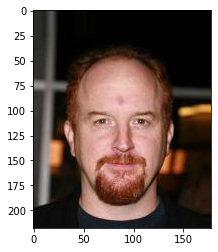

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('img_align_celeba/182672.jpg')
plt.imshow(img)

In [3]:
def get_input_transform():
    
    custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])                                      
     

    return custom_transform

def get_input_tensors(img):
    transf = get_input_transform()
    input_tensor = transf(img).unsqueeze(0)
    input_tensor = input_tensor.to(DEVICE)
    # unsqeeze converts single image to batch of 1
    return input_tensor

We are going to import the model we have already trained in order to continue

In [4]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 128
DEVICE = 'cuda:0' # default GPU device
#DEVICE = 'cpu'
GRAYSCALE = False

In [5]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model


In [6]:
torch.manual_seed(1)
GRAYSCALE=False

##########################
### COST AND OPTIMIZER
##########################

model = resnet101(2, GRAYSCALE)


In [7]:
model.load_state_dict(torch.load('/home/constanza/tfg/TFG/thesis/model_attractiveness.pth'))
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
#Store names of the images and tags
idx2label, cls2label, cls2idx = [], {}, {}

file_path = 'parsed_files/celeba-attractiveness-test.csv'

with open(os.path.abspath(file_path), 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        image_name, label,part = line.strip().split(',')
        idx2label.append(image_name)
        cls2label[image_name] = int(label)
        cls2idx[image_name] = len(idx2label) - 1


(tensor([[ 2.9472, -2.9644]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.9973, 0.0027]], device='cuda:0', grad_fn=<SoftmaxBackward0>))


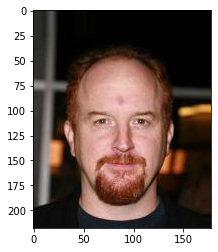

In [10]:
img = get_image('img_align_celeba/182672.jpg')
plt.imshow(img)
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
print(logits)

In [11]:
def get_top_predictions(logits, idx2label):
    softmax_output = logits[1]
    pred_class = torch.argmax(softmax_output, dim=1).item()
    pred_prob = softmax_output[:, pred_class].item()
    # Returns the probability of the class and the predicted class
    return pred_prob, pred_class



Probability: 0.6011004447937012
Predicted class: 0
True class: 1


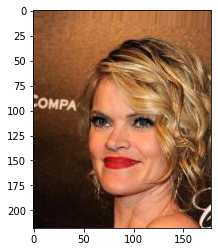

In [12]:
img = get_image('img_align_celeba/182683.jpg')
plt.imshow(img)
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
prob, pred_class = get_top_predictions(logits, idx2label)
print("Probability:", prob)
print("Predicted class:", pred_class)
print("True class:", cls2label['182683.jpg'])




In [13]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.CenterCrop((178, 178)),
        transforms.Resize((128, 128))
    ])  

    return transf

def get_preprocess_transform():    
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf   

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()



In [14]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)
    batch = batch.to(DEVICE)
    
    logits = model(batch)
    softmax_output = logits[1]
    probs = F.softmax(softmax_output, dim=1)
    return probs.detach().cpu().numpy()

In [54]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [55]:
import lime_image

In [56]:
explainer = lime_image.LimeImageExplainer()


The function explain instance has been changed in order to return an extra variable named scores that must containg the weight of importance per pixel

In [57]:
explanation, scores,prob,importance, segments= explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1,
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
#print("Values of the segments:",scores)
#print(prob)
#print("Order of importance:",importance)
#print("Segmented image:",segments)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
print(segments)

[[  0   0   0 ...  16  17  17]
 [  0   0   0 ...  16  17  17]
 [  0   0   0 ...  16  17  17]
 ...
 [233 233 233 ... 241 241 241]
 [233 233 233 ... 241 241 241]
 [233 233 233 ... 241 241 241]]


AxesSubplot(0.125,0.125;0.775x0.755)


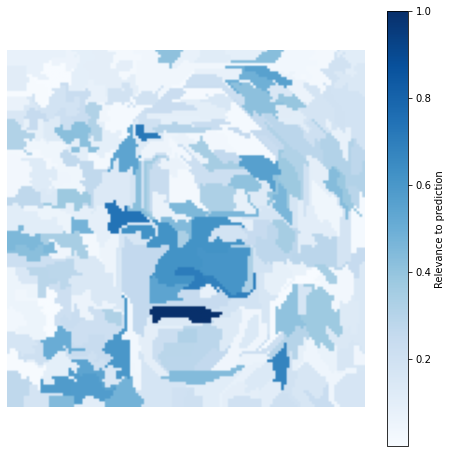

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable  # Make sure to import ScalarMappable

# Assign colors based on the relevance of each segment
def assign_color2(importance, scores):
    colors = []
    i=0
    for segment_id in importance:
        maxi= scores[0][0]
        score = scores[0][i]/maxi  # Get segment relevance
        color_intensity = abs(score)  # Take absolute value as color intensity
        colors.append(color_intensity)  # Use only absolute value as color intensity
        i=i+1
    return colors

# Show segmented image with color intensities based on relevance
def show_segmented_image_with_intensity(segments, importance_order, intensity_values):
    # Create a color matrix based on importance and intensity
    num_segments = len(importance_order)
    colors = np.zeros((segments.shape[0], segments.shape[1], 4))  # RGBA colors
    
    # Scale intensities to map them to shades of blue
    norm = Normalize(vmin=min(intensity_values), vmax=max(intensity_values))
    cmap = plt.cm.Blues
    intensity_colors = cmap(norm(intensity_values))
    
    # Assign colors to each segment based on its importance and intensity
    for segment_id, importance in zip(importance_order, intensity_colors):
        segment_mask = (segments == segment_id)
        colors[segment_mask] = importance
    
    # Show segmented image with colors
    fig, ax = plt.subplots(figsize=(8, 8))
    print(ax)
    im = ax.imshow(colors)
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('Relevance to prediction')
    plt.axis('off')
    fig.savefig('segmentations/182671.jpg', dpi=128)
    plt.show()





colors = assign_color2(importance, scores)
show_segmented_image_with_intensity(segments, importance, colors)


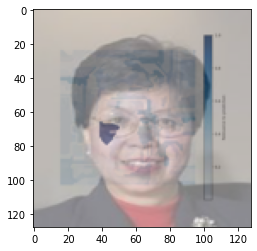

In [23]:
from PIL import Image

def resize_and_show_image_pil(image_path, segment_path, target_size=(128, 128)):
    image = Image.open(image_path)
    segment = Image.open(segment_path)
    resized_image = image.resize(target_size)
    resized_seg = segment.resize(target_size)
    merged_image = Image.new('RGB', (128, 128))
    alpha = 0.5
    merged_image = Image.blend(resized_image.convert('RGBA'), resized_seg.convert('RGBA'), alpha)
    
    merged_image.show()

    plt.imshow(merged_image)

# Ejemplo de uso
resize_and_show_image_pil('img_align_celeba/182671.jpg','segmentations/182671.jpg')  # Reemplaza 'ruta/a/tu/imagen.jpg' con la ruta de tu imagen


In [24]:
from skimage.segmentation import mark_boundaries


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


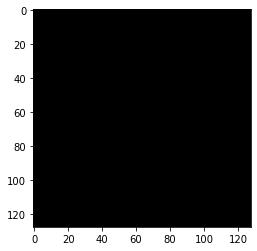

In [25]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
print(mask)

In [25]:
img2 = get_image('img_align_celeba/182638.jpg')

In [26]:
img_t2 = get_input_tensors(img2)
model.eval()
logits2 = model(img_t2)
print(logits2)

(tensor([[ 5.0915, -5.1438]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[9.9996e-01, 3.5880e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>))


In [27]:
prob2, pred_class2 = get_top_predictions(logits2, idx2label)
print("Probabilidad:", prob2)
print("Clase predicha:", pred_class2)

Probabilidad: 0.9999641180038452
Clase predicha: 0


In [28]:
test_pred2 = batch_predict([pill_transf(img2)])
test_pred2.squeeze().argmax()

0

In [29]:
import lime_image

In [30]:
explainer = lime_image.LimeImageExplainer()


In [31]:
explanation2, scores2, prob2, imp2,seg2 = explainer.explain_instance(np.array(pill_transf(img2)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)
print(scores2)
print(prob2)

  0%|          | 0/1000 [00:00<?, ?it/s]

{1: array([-1.12012238e-03,  7.47112864e-04,  7.27851747e-04, -6.92526229e-04,
        6.79852831e-04,  5.64893711e-04, -5.48420955e-04, -5.36320141e-04,
       -5.05268121e-04, -4.89823444e-04, -4.71714225e-04, -4.66261773e-04,
       -4.46548545e-04,  4.44407055e-04, -4.40392971e-04, -4.32120804e-04,
        4.21541493e-04,  4.15738831e-04,  4.04796117e-04, -3.97153925e-04,
       -3.96023859e-04, -3.93768382e-04,  3.89660308e-04, -3.89133246e-04,
       -3.79023372e-04, -3.71112226e-04,  3.68506423e-04,  3.65686827e-04,
        3.58668621e-04,  3.46357610e-04, -3.44117417e-04, -3.44071802e-04,
        3.34051473e-04, -3.32347571e-04, -3.29618037e-04,  3.21625013e-04,
        3.21311516e-04, -3.17427465e-04,  3.04960301e-04, -3.03345793e-04,
       -3.03729931e-04,  2.96486564e-04,  2.92411681e-04, -2.90286849e-04,
        2.89109725e-04, -2.87456370e-04, -2.80158826e-04, -2.78675235e-04,
       -2.78476941e-04,  2.74181954e-04, -2.74286227e-04, -2.73199170e-04,
        2.73882086e-0

AxesSubplot(0.125,0.125;0.775x0.755)


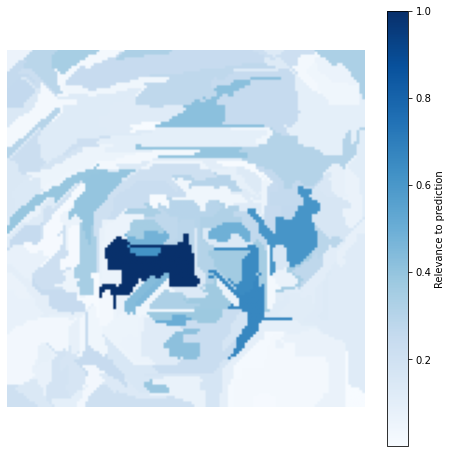

In [32]:
colors2 = assign_color2(imp2, scores2)
show_segmented_image_with_intensity(seg2, imp2, colors2)

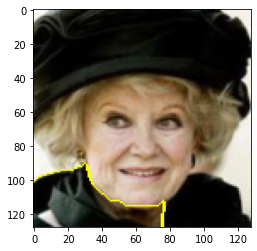

In [46]:
temp2, mask2 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=True, num_features=1, hide_rest=False)
img_boundry2 = mark_boundaries(temp2/255.0, mask2)
plt.imshow(img_boundry2)

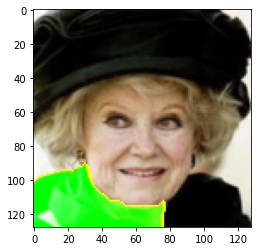

In [77]:
temp, mask = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
img_boundry23 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry23)

Probabilidad: 0.8918507099151611
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.530524730682373
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.5993950366973877
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.8937906622886658
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.6874476671218872
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.8770210146903992
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.5122887492179871
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.7321821451187134
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.5674884915351868
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.9460543394088745
Clase predicha: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

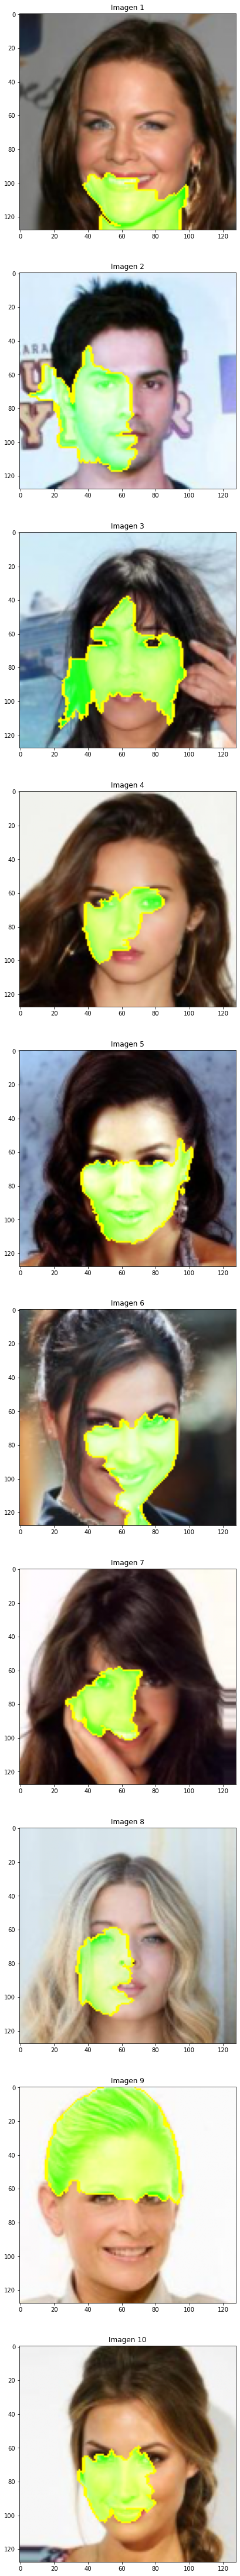

In [28]:
nueva_imagen_male = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
with open('correctly_attractive.csv', 'r') as archivo:
    # Lee el contenido del archivo línea por línea
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        # Cargar la imagen
        path_total = os.path.join(nueva_imagen_male, linea[0])
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        print("Probabilidad:", prob2)
        print("Clase predicha:", pred_class2)
        explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)
        temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
        img_boundry2 = mark_boundaries(temp2/255.0, mask2)
        img_list.append(img_boundry2)
        if lim==10:
            break
            
fig_height = 8 * len(img_list)  
fig_width = 8  
subplot_height = 4  
subplot_width = 6

fig, axs = plt.subplots(len(img_list), 1, figsize=(fig_width, fig_height))

for i, img in enumerate(img_list):
    axs[i].imshow(img)
    axs[i].set_title(f'Imagen {i+1}')

plt.show()

Probabilidad: 0.9999641180038452
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.864870548248291
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.9183050394058228
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.7696936726570129
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.888338565826416
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.9996017813682556
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.5944539308547974
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.7357586622238159
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.9983932375907898
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilidad: 0.9998455047607422
Clase predicha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

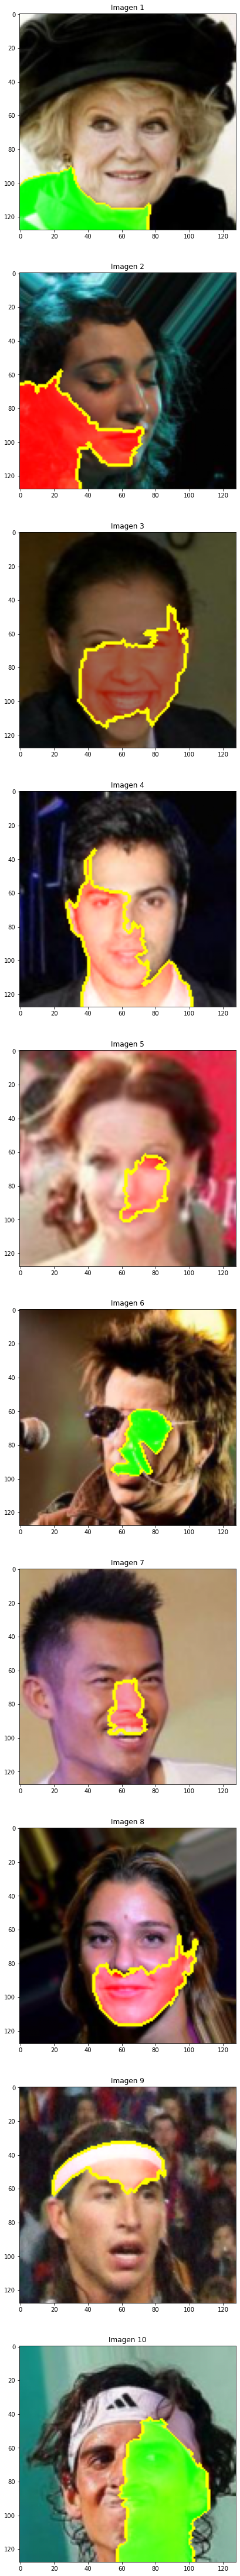

In [38]:
nueva_imagen_male = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
with open('correctly_UNattractive.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen_male, linea[0])
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        print("Probabilidad:", prob2)
        print("Clase predicha:", pred_class2)
        explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)
        temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
        img_boundry2 = mark_boundaries(temp2/255.0, mask2)
        img_list.append(img_boundry2)
        if lim==10:
            break
            
fig_height = 8 * len(img_list)  
fig_width = 8  
subplot_height = 4  
subplot_width = 6  

fig, axs = plt.subplots(len(img_list), 1, figsize=(fig_width, fig_height))

for i, img in enumerate(img_list):
    axs[i].imshow(img)
    axs[i].set_title(f'Image {i+1}') 

plt.show()

In [26]:
print(mask2)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


15 True prediction: 0
Probabilidad: 0.541839599609375
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/199621.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

86 True prediction: 0
Probabilidad: 0.5585907101631165
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/198835.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

102 True prediction: 0
Probabilidad: 0.6788872480392456
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/194523.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

132 True prediction: 0
Probabilidad: 0.7585366368293762
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/186326.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

183 True prediction: 0
Probabilidad: 0.5243291854858398
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/189798.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

229 True prediction: 0
Probabilidad: 0.5075438618659973
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/195495.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

281 True prediction: 0
Probabilidad: 0.5845958590507507
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/193439.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

317 True prediction: 0
Probabilidad: 0.5992975234985352
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/185280.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

328 True prediction: 0
Probabilidad: 0.61125248670578
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/200056.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

335 True prediction: 0
Probabilidad: 0.8261491656303406
Clase predicha: 1
/home/constanza/tfg/TFG/reji/img_align_celeba/188819.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

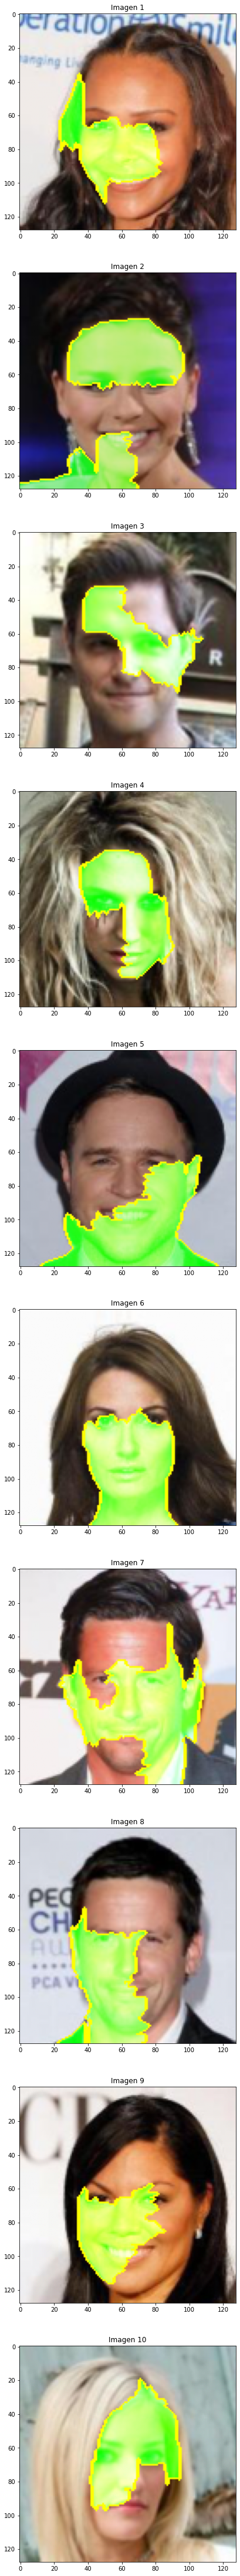

In [111]:
nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
with open('incorrectly_classified.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    for i in range(350):
        next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==0:
            t = t+1
            print(lim, "True prediction:",cls2label[linea[0]] )
            print("Probabilidad:", prob2)
            print("Clase predicha:", pred_class2)
            print(path_total)
            explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_predict, # classification function
                                             top_labels=1, 
                                             hide_color=0, 
                                             num_samples=1000)
            temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)
            img_boundry2 = mark_boundaries(temp2/255.0, mask2)
            img_list.append(img_boundry2)
            
        
            if t==10:
                break
            
fig_height = 8 * len(img_list)  
fig_width = 8 
subplot_height = 4  
subplot_width = 6  

fig, axs = plt.subplots(len(img_list), 1, figsize=(fig_width, fig_height))

for i, img in enumerate(img_list):
    axs[i].imshow(img)
    axs[i].set_title(f'Imagen {i+1}') 

plt.show()

Acc: 0.73125


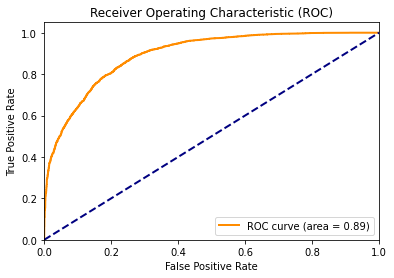

AUC: 0.8938999158149143


In [118]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
y_true = []
y_scores = []

with open('parsed_files/celeba-attractiveness-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==1:
            tp = tp+1
        if pred_class2==0 and cls2label[linea[0]]==0:
            tn = tn+1
        if pred_class2==0:
            prob2 = 1-prob2
            
        y_true.append(cls2label[linea[0]])
        y_scores.append(prob2)

        if lim==8000:
            break
            
print("Acc:", (tp+tn)/lim)

# Calculates ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plots ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


Acc: 0.68975


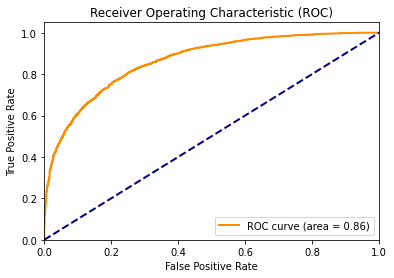

AUC: 0.8643050145228084


In [119]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
y_true = []
y_scores = []

with open('parsed_files/celeba-att-female-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==1:
            tp = tp+1
        if pred_class2==0 and cls2label[linea[0]]==0:
            tn = tn+1
        if pred_class2==0:
            prob2 = 1-prob2
            
        y_true.append(cls2label[linea[0]])
        y_scores.append(prob2)

        if lim==8000:
            break
            
print("Acc:", (tp+tn)/lim)


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plots ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


Acc: 0.7970187945560596


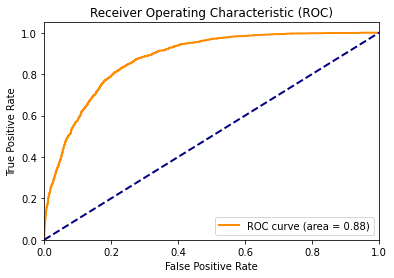

AUC: 0.8754847964273806


In [120]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
y_true = []
y_scores = []

with open('parsed_files/celeba-att-male-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==1:
            tp = tp+1
        if pred_class2==0 and cls2label[linea[0]]==0:
            tn = tn+1
        if pred_class2==0:
            prob2 = 1-prob2
            
        y_true.append(cls2label[linea[0]])
        y_scores.append(prob2)

        if lim==8000:
            break
            
print("Acc:", (tp+tn)/lim)


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


print("AUC:", roc_auc)


Acc: 0.581
581
419


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


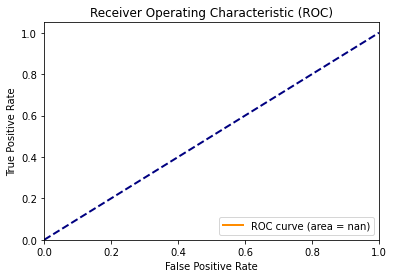

AUC: nan


In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
fn=0
y_true = []
y_scores = []

with open('celeba-att-DP-female-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==1:
            tp = tp+1
        if pred_class2==0 and cls2label[linea[0]]==0:
            tn = tn+1
        if pred_class2==0 and cls2label[linea[0]]==1:
            fn = fn+1
        if pred_class2==0:
            prob2 = 1-prob2
            
        y_true.append(cls2label[linea[0]])
        y_scores.append(prob2)

        if lim==1000:
            break
            
print("Acc:", (tp+tn)/lim)
print(tp)
print(fn)


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


print("AUC:", roc_auc)


Acc: 0.21967213114754097
201


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


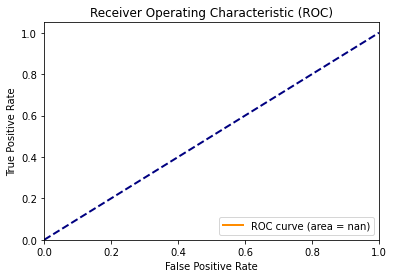

AUC: nan


In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nueva_imagen = '/home/constanza/tfg/TFG/thesis/img_align_celeba/'
lim=0
t=0
total = 0
tp = 0
tn = 0
fn=0
y_true = []
y_scores = []

with open('celeba-att-DP-male-test.csv', 'r') as archivo:
    lineas = csv.reader(archivo)
    img_list = []
    for i in range(1000):
        next(lineas)
    for linea in lineas:
        path_total = os.path.join(nueva_imagen, linea[0])
        tl = linea[0].split('.')[0]
        img = get_image(path_total)
        img_t = get_input_tensors(img)
        model.eval()
        logits = model(img_t)
        prob, pred_class = get_top_predictions(logits, idx2label)
        test_pred = batch_predict([pill_transf(img)])
        test_pred.squeeze().argmax()
        lim=lim+1
        prob2, pred_class2 = get_top_predictions(logits, idx2label)
        if pred_class2==1 and cls2label[linea[0]]==1:
            tp = tp+1
        if pred_class2==0 and cls2label[linea[0]]==0:
            tn = tn+1
        if pred_class2==0 and cls2label[linea[0]]==1:
            fp = fp+1
        if pred_class2==0:
            prob2 = 1-prob2
            
        y_true.append(cls2label[linea[0]])
        y_scores.append(prob2)

        if lim==1000:
            break
            
print("Acc:", (tp+tn)/lim)
print(tp)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)
